In [68]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import VGG16
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [69]:
data_dir = 'E:/3rd year/Data-image'

In [70]:
img_width , img_height = 150 , 150
batch_size = 32
num_classes = 6
epochs = 10
validation_ratio = 0.2
test_ratio = 0.2

In [71]:
train_dir = 'E:/3rd year/train'
test_dir = 'E:/3rd year/test'
validation_dir = 'E:/3rd year/validation'

In [72]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [73]:
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        random.shuffle(images)
        train_images, val_test_images = train_test_split(images, test_size=validation_ratio + test_ratio,
                                                        random_state=42)
        validation_images, test_images = train_test_split(val_test_images, test_size=test_ratio /
                                                                                  (validation_ratio + test_ratio),
                                                         random_state=42)

        for image_name in train_images:
            src = os.path.join(class_dir, image_name)
            dst = os.path.join(train_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copyfile(src, dst)

        for image_name in validation_images:
            src = os.path.join(class_dir, image_name)
            dst = os.path.join(validation_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copyfile(src, dst)

        for image_name in test_images:
            src = os.path.join(class_dir, image_name)
            dst = os.path.join(test_dir, class_name, image_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copyfile(src, dst)

In [74]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [75]:
 validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
 test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [76]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2521 images belonging to 6 classes.


In [77]:
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(img_width, img_height),
batch_size= batch_size,
class_mode='categorical'
)

Found 1090 images belonging to 6 classes.


In [78]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(img_width, img_height),
batch_size=1,
shuffle=False,
class_mode='categorical'
)

Found 1079 images belonging to 6 classes.


In [79]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [80]:
for layer in base_model.layers:
    layer.trainable = False

In [81]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
history = model.fit(
train_generator,
steps_per_epoch=train_generator.samples // train_generator.batch_size,
epochs= epochs,
validation_data=validation_generator,
validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
78/78 [==============================] - 773s 10s/step - loss: 1.3394 - accuracy: 0.7409 - val_loss: 0.2038 - val_accuracy: 0.9246
Epoch 2/10
78/78 [==============================] - 706s 9s/step - loss: 0.2738 - accuracy: 0.8927 - val_loss: 0.1558 - val_accuracy: 0.9393
Epoch 3/10
78/78 [==============================] - 705s 9s/step - loss: 0.2571 - accuracy: 0.9080 - val_loss: 0.2209 - val_accuracy: 0.9256
Epoch 4/10
78/78 [==============================] - 712s 9s/step - loss: 0.2100 - accuracy: 0.9217 - val_loss: 0.1623 - val_accuracy: 0.9467
Epoch 5/10
78/78 [==============================] - 712s 9s/step - loss: 0.1542 - accuracy: 0.9462 - val_loss: 0.1756 - val_accuracy: 0.9439
Epoch 6/10
78/78 [==============================] - 714s 9s/step - loss: 0.1374 - accuracy: 0.9534 - val_loss: 0.1397 - val_accuracy: 0.9522
Epoch 7/10
78/78 [==============================] - 712s 9s/step - loss: 0.1776 - accuracy: 0.9357 - val_loss: 0.1251 - val_accuracy: 0.9504
Epoch 8/10
7

In [84]:
 y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print('Test Accuracy:', test_accuracy)

1079/1079 [==============================] - 234s 216ms/step
Test Accuracy: 0.9777571825764597


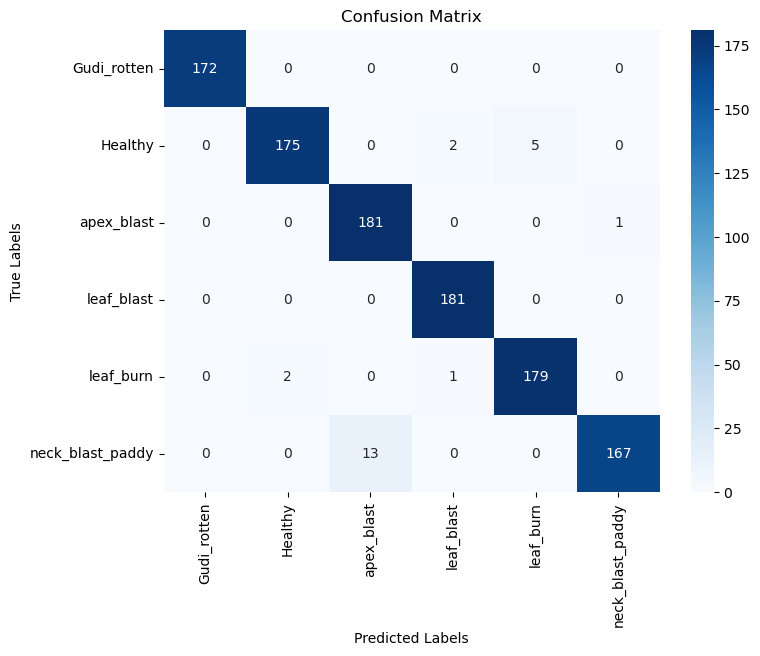

In [85]:
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

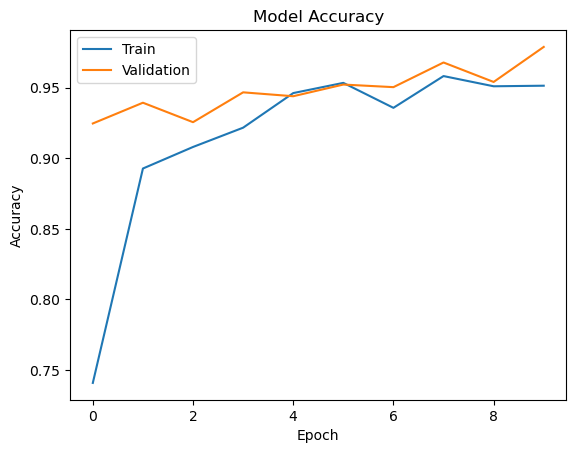

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [88]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


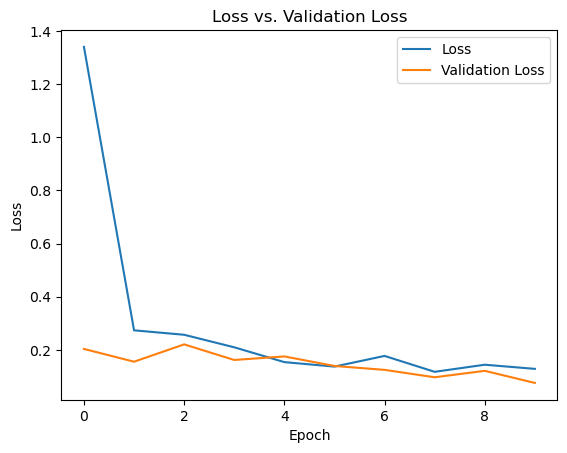

In [89]:
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')
plt.show()

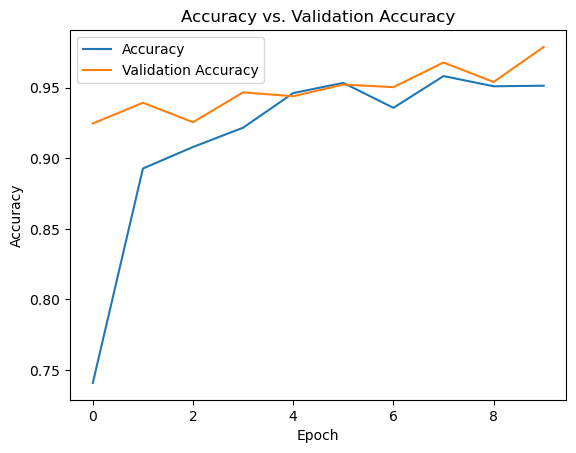

In [90]:
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')
plt.show()

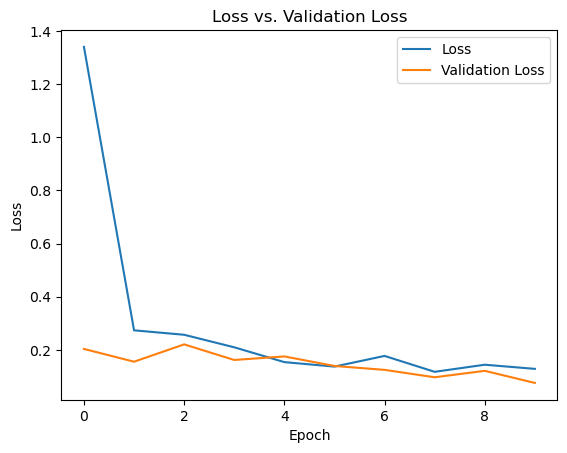

In [91]:
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')
plt.show()

In [97]:
from tensorflow.keras.models import load_model
model.save('F:/4th year/Research Project/PP1/models/trained_model_VGG16.h5')

In [105]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image you want to predict
image_path = 'E:/3rd year/Data-image/leafbl1.jpg'
img = image.load_img(image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = model.predict(img_array)
class_index = np.argmax(predictions[0])
class_label = class_names[class_index]  # Replace class_names with your list of class labels

print("Predicted class:", class_label)

1/1 [==============================] - 0s 96ms/step
Predicted class: leaf_blast


In [108]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = test_generator.classes

# Compute precision, recall, and F1 score
report = classification_report(y_true, y_pred_labels)

print(report)


1079/1079 [==============================] - 226s 209ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       0.99      0.96      0.97       182
           2       0.93      0.99      0.96       182
           3       0.98      1.00      0.99       181
           4       0.97      0.98      0.98       182
           5       0.99      0.93      0.96       180

    accuracy                           0.98      1079
   macro avg       0.98      0.98      0.98      1079
weighted avg       0.98      0.98      0.98      1079

